# Text to image generation with Stable Diffusion and OpenVINO

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

General diffusion models are machine learning systems that are trained to denoise random gaussian noise step by step, to get to a sample of interest, such as an image.
Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference. OpenVINO brings capabilities to run model inference on Intel hardware and opens the door to the fantastic world of diffusion models for everyone!


This notebook demonstrates how to convert and run stable diffusion using OpenVINO.

Notebook contains the following steps:
1. Convert PyTorch models to ONNX format.
2. Convert ONNX models to OpenVINO IR format using Model Optimizer tool.
3. Run Stable Diffusion pipeline with OpenVINO.

## Prerequisites
You also need to accept the model license before downloading or using the weights. In this post we'll use `stable-diffusion-v1-4` model version, so you'll need to  visit [its card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. 

You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In [1]:
!pip install -r requirements.txt

In [2]:
## login to huggingfacehub to get access to pretrained model 
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to C:\Users\eaidova\.huggingface\token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


## Create Pytorch Models pipeline
StableDiffusionPipeline is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code.

First, we load the pre-trained weights of all components of the model.

In addition to the model id `CompVis/stable-diffusion-v1-4`, we're also passing a `use_auth_token` to the from_pretrained method `use_auth_token` to verify that you have indeed accepted the model's license.

In [1]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", use_auth_token=True)

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.
{'trained_betas'} was not found in config. Values will be initialized to default values.


## Convert models to ONNX format

OpenVINO supports PyTorch\* through export to the ONNX\* format. We will use `torch.onnx.export` function for obtaining ONNX, 
you can find more info about it in [PyTorch documentation](https://pytorch.org/docs/stable/onnx.html). 
We need provide model object, input data for model tracing and path for model saving. 
Optioanally, we can provide target onnx opset for conversion and other parameters specified in documentation (e.g. input and output names or dynamic shapes).

The model consists from three important parts:
* Text Encoder for creation condition to generate image from text prompt
* Unet for step by step denoising latent image representation
* Autoencoder (VAE) for decoding latent space to image

Let's convert each part

### Text Encoder

The text-encoder is responsible for transforming the input prompt, e.g. "a photo of an astronaut riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.

Input of text encoder is tensor `input_ids` which contains indexes of tokens from text processed by tokenizer and padded to maximum length accepted by model.
Output of model is 2 tensors: `last_hidden_state` - hidden state from the last MultiHeadAttention layer in model and `pooler_out` - Pooled output for whole model hidden states. We will use `opset_version=14`, because model contains `triu` operation, supported in ONNX only starting from this opset.

In [2]:
import torch

text = 'a photo of an astronaut riding a horse on mars'
text_encoder = pipe.text_encoder
input_ids = pipe.tokenizer(
    text,
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
).input_ids

# switch model to inference mode
text_encoder.eval()

# disable gradients calculation for reducing memory consumption
with torch.no_grad():
    # infer model, just to make sure that it works and get inputs for next pipeline stage
    text_encoder_output = text_encoder(input_ids)
    # export model to ONNX format
    torch.onnx.export(
        text_encoder,  # model instance
        input_ids,  # inputs for model tracing
        'text-encoder.onnx',  # output file for saving result
        input_names=['input_ids'],  # model input name for onnx representation
        output_names=['last_hidden_state', 'pooler_out'],  # model output names for onnx representation
        opset_version=14  # onnx opset version for export
    )

c:\Users\eaidova\Anaconda3\envs\notebooks_env\lib\site-packages\transformers\models\clip\modeling_clip.py:682: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask.fill_(torch.tensor(torch.finfo(dtype).min))
c:\Users\eaidova\Anaconda3\envs\notebooks_env\lib\site-packages\transformers\models\clip\modeling_clip.py:222: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
c:\Users\eaidova\Anaconda3\envs\notebooks_env\lib\site-packages\transformers\models\clip\

### U-net

Unet model has 3 inputs:
* `sample` - latent image sample from previous step, generation process has not been started yet, so we will use random noise
* `timestep` - current scheduler step
* `encoder_hidden_state` - hidden state of text encoder.

Model predicts the `sample` state for the next step.

Unet contains `brodcast_to` operator which is not supported for onnx conversion yet, but there is equivalent operation in onnx named `Expand`, let's define custom symbolic operation for this case. More details about custom operations can be found on this [page](https://pytorch.org/docs/stable/onnx.html#custom-operators)


In [5]:
from torch.onnx import register_custom_op_symbolic


# define custom symbolic function
def broadcast_to_onnx(ctx: torch.onnx.SymbolicContext, g: torch._C.Graph, input, shape):
    return g.op('Expand', input, shape)


# register custom symbolic function with name brodcast_to to main pytorch domain and opset 13
register_custom_op_symbolic("::broadcast_to", broadcast_to_onnx, 13)

In [6]:
import numpy as np
latents_shape = (2, 4, 512 // 8, 512 // 8)
latents = torch.randn(latents_shape)
t = torch.from_numpy(np.array(1, dtype=float))

# model size > 2Gb, it will be represented as onnx with external data files, we will store it in separated directory for avoid a lot of files in current directory
!mkdir unet

max_length = input_ids.shape[-1]

# we plan to use unet with classificator free guidence, in this cace conditionaly generated text embeddings should be concatenated with uncoditional
uncond_input = pipe.tokenizer([""], padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = pipe.text_encoder(uncond_input.input_ids)[0]
encoder_hidden_state = torch.cat([uncond_embeddings, text_encoder_output[0]])

# to make sure that model works and save input for vae decoder
output_latents = pipe.unet(latents, t, encoder_hidden_state)[0]

with torch.no_grad():
    torch.onnx.export(
        pipe.unet, 
        (latents, t, encoder_hidden_state), 'unet/unet.onnx',
        input_names=['sample', 'timestep', 'encoder_hidden_state'],
        output_names=['out_sample']
    )


A subdirectory or file unet already exists.
c:\Users\eaidova\Anaconda3\envs\notebooks_env\lib\site-packages\torch\nn\functional.py:2515: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  _verify_batch_size([input.size(0) * input.size(1) // num_groups, num_groups] + list(input.size()[2:]))
c:\Users\eaidova\Anaconda3\envs\notebooks_env\lib\site-packages\diffusers\models\attention.py:239: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, round

### VAE

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net model. The decoder, conversely, transforms the latent representation back into an image.

During latent diffusion training, the encoder is used to get the latent representations (latents) of the images for the forward diffusion process, which applies more and more noise at each step. During inference, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. As we will see during inference we **only need the VAE decoder**.

In our inference pipeline, we will need only decoding part of VAE, but forward function, which used for tracing runs encoding too. For obtaining only necessary part of model, we will wrap it into new model class.

In [9]:
class VAEDecoderWrapper(torch.nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    def forward(self, latents):
        return self.vae.decode(latents)


vae_decoder = VAEDecoderWrapper(pipe.vae)

latents_uncond, latents_text = output_latents[0].unsqueeze(0), output_latents[1].unsqueeze(0)
latents = latents_uncond + 7.5 * (latents_text - latents_uncond)

vae_decoder.eval()
with torch.no_grad():
    torch.onnx.export(vae_decoder, latents, 'vae_decoder.onnx', input_names=['latents'], output_names=['sample'])

c:\Users\eaidova\Anaconda3\envs\notebooks_env\lib\site-packages\torch\nn\functional.py:2515: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  _verify_batch_size([input.size(0) * input.size(1) // num_groups, num_groups] + list(input.size()[2:]))
c:\Users\eaidova\Anaconda3\envs\notebooks_env\lib\site-packages\diffusers\models\resnet.py:39: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert x.shape[1] == self.channels


In [10]:
# to reduce memory consumption, remove pipeline form memory as we will not use it anymore
del pipe

## Convert models using OpenVINO Model Optimizer API

While ONNX models are directly supported by OpenVINO™, it can be useful to convert them to IR format to take advantage of advanced OpenVINO optimization tools and features. `mo.convert' function can be used for converting model using OpenVINO Model Optimizer capabilities. It returns of instance OpenVINO Model class, which is ready to use in python interface and can be serialized to IR for next usages.

In [11]:
from openvino.tools import mo
from openvino.runtime import serialize

text_encoder = mo.convert(input_model='text-encoder.onnx', data_type='FP16')
serialize(text_encoder, 'text_encoder.xml')
unet = mo.convert(input_model='unet/unet.onnx', data_type='FP16')
serialize(unet, 'unet.xml')
vae_decoder = mo.convert(input_model='vae_decoder.onnx', data_type='FP16')
serialize(vae_decoder, 'vae_decoder.xml')


## Prepare Inference Pipeline

Putting it all together, let's now take a closer look at how the model works in inference by illustrating the logical flow.

<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, it is recommended using one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py)
- [DDIM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py)
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py)(we will use it in our pipeline)

Theory on how the scheduler algorithm function is out of scope for this notebook, but in short one should remember that they compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, we recommend looking into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated given number of times (by default 50) to step-by-step retrieve better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.

In [14]:
import inspect
from typing import List, Optional, Union
import numpy as np
import torch

from transformers import CLIPTokenizer
from diffusers.pipeline_utils import DiffusionPipeline
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler
from openvino.runtime import Model


class OVStableDiffusionPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae: Model,
        text_encoder: Model,
        tokenizer: CLIPTokenizer,
        unet: Model,
        scheduler: Union[DDIMScheduler, PNDMScheduler, LMSDiscreteScheduler],
    ):
        super().__init__()
        self.scheduler = scheduler.set_format("np")
        self.vae = vae
        self.text_encoder = text_encoder
        self.unet = unet
        self._text_encoder_output = text_encoder.output(0)
        self._unet_output = unet.output(0)
        self._vae_output = vae.output(0)
        self.height = self.unet.input(0).shape[2] * 8
        self.width = self.unet.input(0).shape[3] * 8
        self.tokenizer = tokenizer

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        eta: Optional[float] = 0.0,
        latents: Optional[np.array] = None,
        output_type: Optional[str] = "pil",
        gif: Optional[bool] = False,
        **kwargs,
    ):

        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        img_buffer = []
        # get prompt text embeddings
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        text_embeddings = self.text_encoder(text_input.input_ids)[self._text_encoder_output]
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            max_length = text_input.input_ids.shape[-1]
            uncond_input = self.tokenizer(
                [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="np"
            )
            uncond_embeddings = self.text_encoder(uncond_input.input_ids)[self._text_encoder_output]

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = np.concatenate([uncond_embeddings, text_embeddings])

        # get the initial random noise unless the user supplied it
        latents_shape = (batch_size, 4, self.height // 8, self.width // 8)
        if latents is None:
            latents = np.random.randn(
                *latents_shape
            )
        else:
            if latents.shape != latents_shape:
                raise ValueError(f"Unexpected latents shape, got {latents.shape}, expected {latents_shape}")

        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        if accepts_offset:
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)

        # if we use LMSDiscreteScheduler, let's make sure latents are mulitplied by sigmas
        if isinstance(self.scheduler, LMSDiscreteScheduler):
            latents = latents * self.scheduler.sigmas[0]

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        for i, t in enumerate(self.progress_bar(self.scheduler.timesteps)):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = np.concatenate([latents] * 2) if do_classifier_free_guidance else latents
            if isinstance(self.scheduler, LMSDiscreteScheduler):
                sigma = self.scheduler.sigmas[i]
                # the model input needs to be scaled to match the continuous ODE formulation in K-LMS
                latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            # predict the noise residual
            noise_pred = self.unet([latent_model_input, t, text_embeddings])[self._unet_output]
            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            if isinstance(self.scheduler, LMSDiscreteScheduler):
                latents = self.scheduler.step(noise_pred, i, latents, **extra_step_kwargs)["prev_sample"]
            else:
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs)["prev_sample"]
            if gif:
                image = self.vae(1 / 0.18215 * latents)[self._vae_output]
                image = (image / 2 + 0.5).clip(0, 1)
                image = image.transpose(0, 2, 3, 1)
                if output_type == "pil":
                    image = self.numpy_to_pil(image)
                img_buffer.extend(image)

        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        image = self.vae(latents)[self._vae_output]

        image = (image / 2 + 0.5).clip(0, 1)
        image = image.transpose(0, 2, 3, 1)
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        return {"sample": image, 'iterations': img_buffer}

## Configure Inference Pipeline

First of all, we should create instance of our OpenVINOModel wrapper. We use it for more convinient getting inference results.

In [16]:
from openvino.runtime import Core
core = Core()
text_enc = core.compile_model('text_encoder.xml', device='CPU')

In [17]:
unet_model = core.compile_model('unet.xml', device='CPU')

In [18]:
vae = core.compile_model('vae_decoder.xml', device='CPU')

Besides, models tokenizer and scheduler are also important parts of pipeline. Let's define them and put all components together

In [19]:
from transformers import CLIPTokenizer
from diffusers.schedulers import LMSDiscreteScheduler

lms = LMSDiscreteScheduler(
    beta_start=0.00085, 
    beta_end=0.012, 
    beta_schedule="scaled_linear"
)
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')

ov_pipe = OVStableDiffusionPipeline(
    tokenizer=tokenizer,
    text_encoder=text_enc,
    unet=unet_model,
    vae=vae,
    scheduler=lms
)

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Now, we are ready to define text prompt for generation and run inference pipeline

In [20]:
import ipywidgets as widgets

text_prompt = widgets.Text(value='A pikachu fine dining with a view to the Eiffel Tower', description='your text')
text_prompt

Text(value='A pikachu fine dining with a view to the Eiffel Tower', description='your text')

In [26]:
print(f'Input text: {text_prompt.value}')

Input text: A pikachu fine dining with a view to the Eiffel Tower


In [21]:
result = ov_pipe(text_prompt.value, num_inference_steps=50, gif=True)

  0%|          | 0/50 [00:00<?, ?it/s]

And finally, let's convert the image to PIL so we can display or save it. 
Our pipeline returns several results: `sample` contains final generated image, `iterations` contains list of intermediate results for each step.

In [22]:
final_image = result['sample'][0]
all_frames = result['iterations']
img = next(iter(all_frames))
img.save(fp='result.gif', format='GIF', append_images=iter(all_frames), save_all=True, duration=len(all_frames) * 5, loop=0)
final_image.save('result.png')

Now is show time!

Input text: A pikachu fine dining with a view to the Eiffel Tower


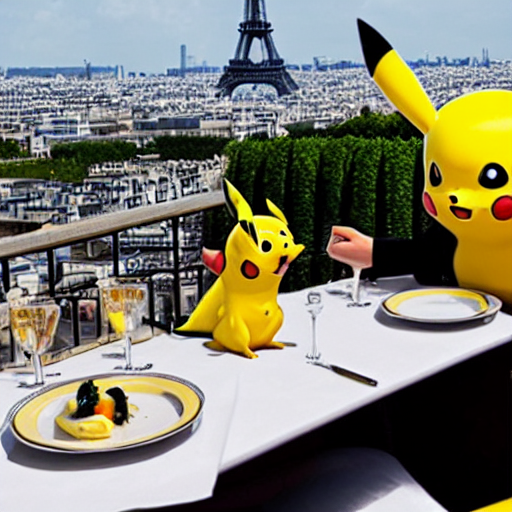

In [24]:
import ipywidgets as widgets

print(f'Input text: {text_prompt.value}')
display(final_image)

Nice, as we can see the picture has quite a definition 🔥.
Moving slider we also can view steps history how noise and blurry outlines turn into an image.

In [25]:
@widgets.interact(step=(1, len(all_frames)))
def display_step(step=0):
    display(all_frames[step - 1])

interactive(children=(IntSlider(value=1, description='step', max=50, min=1), Output()), _dom_classes=('widget-…